# Circadian Detection Pipeline

In [331]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [332]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [333]:
%%capture

import circadian
reload(circadian)


first_day_with_data = '2024-07-14'
today = '2025-03-25'

all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]

all_raw_data = circadian.fetch_raw_data(day_data, all_days)


In [334]:
import circadian
reload(circadian)

all_processed = circadian.process_raw_data(all_raw_data)


c:\dev\Brainwave-Processor\notebooks\CircadianDetection\circadian.py:92: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  local_valley_idx = window.idxmin()
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\pandas\core\generic.py:4106: RuntimeWarning: invalid value encountered in cast
  indices = np.asarray(indices, dtype=np.intp)


In [335]:
import sleep_events
reload(sleep_events)

import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

Getting circadian rhythm reviews
Starting to process circadian rhythm reviews


# Extracting & drawing features

In [336]:
joined_lep_df = None
joined_lt1_df = None
joined_mp1_df = None


In [337]:
def merge_all_types():
    out = []
    if joined_lep_df is not None:
        out.append(joined_lep_df)
    if joined_lt1_df is not None:
        out.append(joined_lt1_df)
    if joined_mp1_df is not None:
        out.append(joined_mp1_df)
        
    if len(out) == 0:
        return None
    if len(out) == 1:
        return out[0]
    
    # Merge all DataFrames in the list
    result = out[0]
    for df in out[1:]:
        result = pd.merge(result, df, on='dayAndNightOf', how='outer')
    
    # Detect types and create merged columns
    types = set()
    for col in result.columns:
        if col.endswith('_cr_datetime'):
            type_name = col.split('_cr_')[0]
            types.add(type_name)
    
    # Create merged columns for each type
    for type_name in types:
        # Datetime
        cr_datetime = f'{type_name}_cr_datetime'
        det_datetime = f'{type_name}_det_time'
        result[f'{type_name}_merge_datetime'] = result[cr_datetime].fillna(result[det_datetime])
        
        # Temperature
        cr_temp = f'{type_name}_cr_temp'
        det_temp = f'{type_name}_det_temp'
        result[f'{type_name}_merge_temp'] = result[cr_temp].fillna(result[det_temp])
        
        # Prominence (only exists in cr data)
        if f'{type_name}_cr_prominence' in result.columns:
            result[f'{type_name}_merge_prominence'] = result[f'{type_name}_cr_prominence']
    
    return result

merged = merge_all_types()
if merged is not None:
    merged.head()
else:
    print("No merged data") 

No merged data


In [338]:
import circadian
reload(circadian)

post_lep_stats = circadian.calc_avg_mins_after_lep(all_processed, merge_all_types(), 2.5 * 60)
if post_lep_stats is not None:
    display(post_lep_stats.describe())
else:
    print("No post LEP stats")


No post LEP stats


In [339]:
import circadian
reload(circadian)


def do_it_all(day: str, start_time: str = '06:00:00Z', end_time: str = '12:00:00Z'):
    merged = merge_all_types()
    chart = circadian.do_it_all(day_data, day, start_time, end_time, merged, all_processed, post_lep_stats)
    display(chart)
    if merged is not None:
        vs_lep_avg = circadian.compare_night_to_average(all_processed, merged, post_lep_stats, day)
        display("Comparing to average period after LEP", vs_lep_avg)

do_it_all('2024-08-06', '19:00:00Z', '08:00:00Z') 

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

In [385]:
def debug_day(day):
    if all_processed.get(day) is None:
        print(f"No all_processed data for day {day}")
        return
    merged_df = merge_all_types()
    if merged_df is None:
        print(f"No merged data at all yet")
        return
    else:
        merged_df_day = merged_df[merged_df['dayAndNightOf'] == day]
        if merged_df_day.empty:
            print(f"No merged data for day {day}")
            return
        else:
            lep_time = merged_df_day['LEP_cr_datetime'].iloc[0]
            if pd.isna(lep_time):
                print(f"No LEP time found for day {day}")
            else:
                print(f"LEP time found for day {day}: {lep_time}")

    if 'dd' in all_processed[day]:
        dd = all_processed[day]['dd']
        if 'wakeTime' in dd.columns:
            wake_time = dd['wakeTime'].iloc[0]
            if pd.notna(wake_time):
                print(f"Wake time found for day {day}: {wake_time}"
    else:
        print(f"No dd data for day {day}")  

debug_day('2025-03-25')


LEP time found for day 2025-03-25: 2025-03-25 21:50:00+00:00


# Detecting LEP

In [340]:
import circadian
reload(circadian)

cr_known_lep = circadian.cr_known(cr_df, 'LEP')
cr_known_lep.head()

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140
7,2024-07-21,2024-07-21 22:40:00+01:00,36.97,0.340
8,2024-07-22,2024-07-22 22:42:00+01:00,36.97,0.390
9,2024-07-23,2024-07-23 23:06:00+01:00,37.04,0.360


In [341]:
import circadian
reload(circadian)

joined_lep_df, does_not_match_cr_lep = circadian.detect_leps(all_processed, cr_known_lep)

display(joined_lep_df['LEP_diff'].describe())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

does_not_match_cr_lep.head()


count                          153
mean     0 days 00:07:27.450980392
std      0 days 00:23:14.630459170
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:01:00
75%                0 days 00:02:00
max                0 days 02:16:00
Name: LEP_diff, dtype: object

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
248,2025-03-19,2025-03-19 22:36:00+00:00,37.01,0.39,Detected,"Use 20:20 from ['20:20', '22:37', '23:54'] as it's closest to historical average of 20:52",2025-03-19 20:20:00+00:00,36.720000,0 days 02:16:00
213,2025-02-12,2025-02-12 20:30:00+00:00,37.25,1.00,Detected,"Use 22:24 from ['20:30', '22:24'] as it's closest to historical average of 21:46",2025-02-12 22:24:00+00:00,36.760000,0 days 01:54:00
244,2025-03-15,2025-03-15 22:14:00+00:00,36.86,0.22,Detected,Use 20:22 from ['20:22'] as it's closest to historical average of 21:43,2025-03-15 20:22:00+00:00,36.725556,0 days 01:52:00
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.14,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.060000,0 days 01:44:00
166,2024-12-27,2024-12-27 21:30:00+00:00,37.11,0.11,Detected,Use 23:07 from ['23:07'] as it's closest to historical average of 21:34,2024-12-27 23:07:00+00:00,36.540000,0 days 01:37:00


In [342]:
import circadian
reload(circadian)


display(circadian.display_stats(joined_lep_df, does_not_match_cr_lep, 'LEP'))

In [343]:
joined_lep_df

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405,Detected,Selected last peak of the evening (no historical data available),2024-07-14 22:47:00+01:00,37.02,0 days 00:01:00
1,2024-07-15,NaT,NaN,NaN,Detected,Selected last peak of the evening (no historical data available),2024-07-15 22:34:00+01:00,37.17,NaT
2,2024-07-16,NaT,NaN,NaN,Detected,Selected last peak of the evening (no historical data available),2024-07-16 23:16:00+01:00,37.09,NaT
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.06,0 days 01:44:00
4,2024-07-18,NaT,NaN,NaN,Not found,No usable peaks found,NaT,NaN,NaT
...,...,...,...,...,...,...,...,...,...
253,2025-03-24,2025-03-24 21:44:00+00:00,37.21,0.700,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 21:53,2025-03-24 21:44:00+00:00,37.22,0 days 00:00:00
254,2025-03-25,2025-03-25 21:50:00+00:00,36.97,0.140,Error,positional indexers are out-of-bounds,NaT,NaN,NaT
255,2025-03-26,2025-03-26 21:06:00+00:00,36.92,0.160,NaN,NaN,NaT,NaN,NaT
256,2025-03-27,2025-03-27 21:20:00+00:00,37.14,0.270,NaN,NaN,NaT,NaN,NaT


In [344]:
# Nights where it's going to be pretty tricky for the algo, for instance.
# It's ok to mark up some nights manually.
lep_tricky_nights = [
    # A double peak and I have correctly labelled the later one as LEP but can see why the algo chooses the first (closer to historical avg)
    '2024-09-20', '2024-08-11',

    # Algo has chosen a better peak but my UI won't let me correct mine
    '2024-09-12',

    # Very early data when CR is messed up
    '2024-07-25'
]

# This is just temporary, it should be fixed in the UI now
lep_fixed_my_own = []

lep_does_not_match_cr_days = does_not_match_cr_lep['dayAndNightOf'].unique()
lep_does_not_match_cr_days = [bd for bd in lep_does_not_match_cr_days if bd not in lep_fixed_my_own and bd not in lep_tricky_nights]
lep_does_not_match_cr_days


['2025-03-19',
 '2025-02-12',
 '2025-03-15',
 '2024-07-17',
 '2024-12-27',
 '2024-12-21',
 '2025-03-11',
 '2025-03-01',
 '2024-08-07',
 '2024-09-05',
 '2024-08-10',
 '2024-11-29',
 '2024-09-08',
 '2024-10-30',
 '2024-12-07']

In [345]:
#do_it_all('2024-07-17', '19:00:00Z', '08:00:00Z')
# df, dd = get_data_for_day('2024-08-29')
# df.head()


To solve:
* If there's no data values around where we expect LEP ot be (2025-01-05)


# Detecting LT1 

In [346]:
import circadian
reload(circadian)

cr_known_lt1 = circadian.cr_known(cr_df, 'LT1')
cr_known_lt1.head()

,dayAndNightOf,LT1_cr_datetime,LT1_cr_temp,LT1_cr_prominence
1,2024-07-15,2024-07-16 00:32:00+01:00,36.32,0.61
7,2024-07-21,2024-07-22 00:30:00+01:00,36.31,0.53
8,2024-07-22,2024-07-23 00:32:00+01:00,36.40,0.26
9,2024-07-23,2024-07-24 01:04:00+01:00,36.43,0.11
10,2024-07-24,2024-07-25 00:54:00+01:00,36.37,0.21


In [347]:
import circadian
reload(circadian)

# Test
# lt1_det_df = circadian.extract_lt1(all_processed)
# lt1_det_df.head()


<module 'circadian' from 'c:\\dev\\Brainwave-Processor\\notebooks\\CircadianDetection\\circadian.py'>

In [348]:
import circadian
reload(circadian)

merged = merge_all_types()
joined_lt1_df, does_not_match_cr_lt1 = circadian.detect_lt1(all_processed, cr_known_lt1, merged)

display(joined_lt1_df['LT1_diff'].describe())
display(len(does_not_match_cr_lt1))

does_not_match_cr_lt1.head()

count                           26
mean     0 days 00:38:11.538461538
std      0 days 00:52:05.672653759
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:07:30
75%                0 days 00:48:00
max                0 days 02:43:00
Name: LT1_diff, dtype: object

13

,dayAndNightOf,LT1_cr_datetime,LT1_cr_temp,LT1_cr_prominence,LT1_det_status,LT1_det_reason,LT1_det_time,LT1_det_temp,LT1_diff
23,2024-08-06,2024-08-07 02:02:00+01:00,36.40,NaN,Detected,Selected first stable valley at 23:19 (after LEP at 21:48),2024-08-06 23:19:00+01:00,36.66,0 days 02:43:00
31,2024-08-14,2024-08-15 02:04:00+01:00,36.36,0.48,Detected,Selected first stable valley at 23:35 (after LEP at 22:10),2024-08-14 23:35:00+01:00,36.49,0 days 02:29:00
17,2024-07-31,2024-08-01 02:54:00+01:00,36.55,NaN,Detected,Selected first stable valley at 00:34 (after LEP at 23:40),2024-08-01 00:34:00+01:00,37.13,0 days 02:20:00
45,2024-08-28,2024-08-29 01:30:00+01:00,36.43,0.73,Detected,Selected first stable valley at 23:45,2024-08-28 23:45:00+01:00,36.48,0 days 01:45:00
28,2024-08-11,2024-08-12 01:34:00+01:00,36.38,0.16,Detected,Selected first stable valley at 23:50,2024-08-11 23:50:00+01:00,36.48,0 days 01:44:00


In [349]:
display(circadian.display_stats(joined_lt1_df, does_not_match_cr_lt1, 'LT1'))

In [350]:
#do_it_all('2024-07-31', '19:00:00Z', '08:00:00Z') 

# Exploring initial drop after LEP

Identifying LT1 is proving tricky.  It doesn't always plummet in a nice clean way to a nice clean bottom.

Might be easier to identify features like amount of drop in first 2 hours after LEP.

Or % of total night's low covered in first 2 hours.

May be interesting to see all charts on one, for the first 2 hours after LEP, that sort of thing.

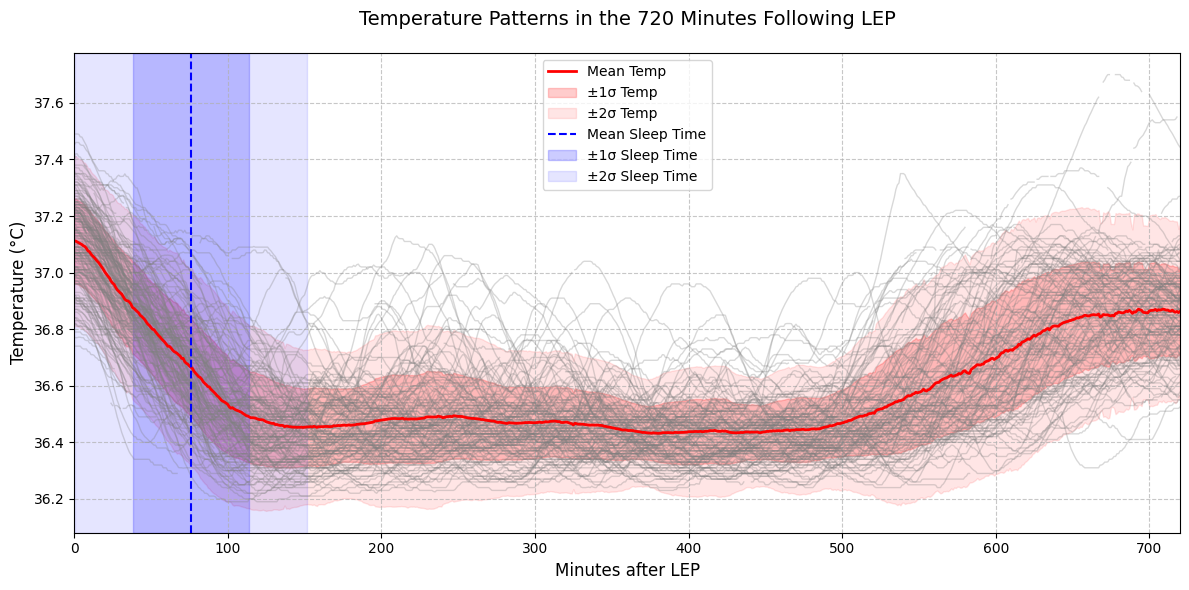

In [351]:

import matplotlib as plt
import circadian
reload(circadian)

fig = circadian.plot_post_lep_periods_matplotlib(all_processed, merge_all_types(), 12 * 60)

In [352]:
do_it_all('2025-01-14', '19:00:00Z', '08:00:00Z') 

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

'Comparing to average period after LEP'

None

nights_failing_to_see_lep = ['2025-03-18']
nights_look_wrong = ['2025-03-15']

Next

* Detect amount of time above and below mean, and how much.
* Look at steep and slow descenders.
* Look at those that don't descend cleanly.
* Do any of these correlate to e.g. more or stronger deep sleep? 

In [354]:
# import circadian
# reload(circadian)

# # Create list to store results
# all_nights_analysis = []

# m = merge_all_types()
# # Analyze each night
# for day in all_processed.keys():
#     metrics = circadian.compare_night_to_average(all_processed, m, post_lep_stats, day)
#     if metrics is not None:
#         metrics['dayAndNightOf'] = day
#         all_nights_analysis.append(metrics)

# # Convert to DataFrame
# nights_df = pd.DataFrame(all_nights_analysis)

# # Reorder columns to put dayAndNightOf first
# cols = ['dayAndNightOf'] + [col for col in nights_df.columns if col != 'dayAndNightOf']
# nights_df = nights_df[cols]

# # Sort by date
# nights_df = nights_df.sort_values('dayAndNightOf')
# nights_df.head()

TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

In [355]:
# Convert dayAndNightOf to string in both dataframes
nights_df['dayAndNightOf'] = nights_df['dayAndNightOf'].astype(str)
day_data['dayAndNightOf'] = day_data['dayAndNightOf'].astype(str)

# Merge the dataframes
merged_for_corr = pd.merge(nights_df, day_data, on='dayAndNightOf', how='inner')

# Get numeric columns from day_data
numeric_cols = day_data.select_dtypes(include=['int64', 'float64']).columns

timedelta_cols = merged_for_corr.select_dtypes(include=['timedelta64[ns]']).columns
for col in timedelta_cols:
    merged_for_corr[col] = merged_for_corr[col].dt.total_seconds() / 60  # Convert to minutes

# Calculate correlations with valid counts
correlations_below_mean = []
correlations_above_mean = []
for col in numeric_cols:
    # Count valid pairs (where both columns have non-null values)
    valid_count = merged_for_corr[['minutes_below_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['minutes_below_mean'].corr(merged_for_corr[col])
        correlations_below_mean.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

    valid_count = merged_for_corr[['minutes_above_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['minutes_above_mean'].corr(merged_for_corr[col])
        correlations_above_mean.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

# Convert to DataFrame and sort by absolute correlation
corr_below_mean_df = pd.DataFrame(correlations_below_mean)
corr_below_mean_df['abs_correlation'] = corr_below_mean_df['correlation'].abs()
corr_below_mean_df = corr_below_mean_df.sort_values('abs_correlation', ascending=False)
corr_below_mean_df = corr_below_mean_df.drop('abs_correlation', axis=1)


corr_above_mean_df = pd.DataFrame(correlations_above_mean)
corr_above_mean_df['abs_correlation'] = corr_above_mean_df['correlation'].abs()
corr_above_mean_df = corr_above_mean_df.sort_values('abs_correlation', ascending=False)
corr_above_mean_df = corr_above_mean_df.drop('abs_correlation', axis=1)


# Display top correlations
print("Top correlations with minutes_below_mean (minimum 10 valid pairs):")
display(corr_below_mean_df)
print("Top correlations with minutes_above_mean (minimum 10 valid pairs):")
display(corr_above_mean_df)

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf

Top correlations with minutes_below_mean (minimum 10 valid pairs):


c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf

,column,correlation,valid_count
726,coreBodyTemp:GotIntoBedToMiddleOfSleep:mean,-0.683344,131
1912,circadian:combined:entries:NL:minsSinceReadyToSleep:vsDayMinus1,0.679691,16
599,circadian:combined:entries:LEP:temp,-0.652946,152
1830,circadian:basic:entries:LT1:temp:vsDayMinus1,0.650014,16
729,coreBodyTemp:GotIntoBedToMiddleOfSleep:percentile90,-0.649875,131
...,...,...,...
1995,events:startingPaidWork:count,NaN,23
2025,events:luminette:count,NaN,24
2027,events:sexWithClimax:count,NaN,30
2028,events:sexWithoutClimax:count,NaN,30


Top correlations with minutes_above_mean (minimum 10 valid pairs):


,column,correlation,valid_count
580,circadian:basic:entries:LEP:temp,0.682553,162
599,circadian:combined:entries:LEP:temp,0.675557,152
1831,circadian:basic:entries:LT1:temp:onDayMinus1,0.674565,16
1956,circadian:combined:entries:MP1:minsSinceSunsetEnd:onDayMinus1,-0.654140,14
729,coreBodyTemp:GotIntoBedToMiddleOfSleep:percentile90,0.651422,131
...,...,...,...
1995,events:startingPaidWork:count,NaN,23
2025,events:luminette:count,NaN,24
2027,events:sexWithClimax:count,NaN,30
2028,events:sexWithoutClimax:count,NaN,30


In [356]:
from notebooks.Util.MlKeys import sleep_factors, potential_sleep_affectors

#cols_to_include = [c for c in corr_df['column'] if not (c.startswith('circadian') or c.startswith('coreBodyTemp'))]

#use = corr_below_mean_df[corr_below_mean_df['column'].isin(potential_sleep_affectors)]

use = corr_above_mean_df[corr_above_mean_df['column'].isin(sleep_factors)]
df = use[use['correlation'].abs() > 0.1]
df

,column,correlation,valid_count
822,coreBodyTemp:AsleepToAwake:percentile90,0.424067,146
819,coreBodyTemp:AsleepToAwake:mean,0.418171,146
846,o2:AsleepToAwake:percentile90,0.363233,71
821,coreBodyTemp:AsleepToAwake:percentile10,0.339696,146
1725,night:aggregated:microwakingsWithinRemPerHour,0.241435,102
1724,night:aggregated:microwakingsPerHour,0.232130,102
908,night:yasa:adjusted:wakingsWithDurationCount,0.225027,102
2012,movement:AsleepToAwake:mean,0.221043,31
843,o2:AsleepToAwake:mean,0.183301,71
1152,night:yasaExtended:N3:alphaabs:mean,-0.175712,100


In [357]:
import altair as alt


col = "night:yasaExtended:N3:alphaabs:mean"
against = "minutes_above_mean"



plot_df = pd.DataFrame({
    'dayAndNightOf': merged_for_corr['dayAndNightOf'],
    'x': merged_for_corr[col],
    'y': merged_for_corr[against]
}).dropna()  # Remove any rows with missing values

# Calculate correlation
correlation = plot_df['x'].corr(plot_df['y'])

# Create scatter plot with trend line
scatter = alt.Chart(plot_df).mark_circle().encode(
    x=alt.X('x:Q', 
            title=col,
            scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', 
            title=against,
            scale=alt.Scale(zero=False)),
    tooltip=['dayAndNightOf', 
            alt.Tooltip('x:Q', format='.2f'),
            alt.Tooltip('y:Q', format='.2f')]
)

# Add trend line
trend_line = scatter.transform_regression('x', 'y').mark_line(
    color='red',
    strokeDash=[8, 4]
)

# Combine scatter and trend line
chart = (scatter + trend_line).properties(
    width=600,
    height=400,
    title=f'{against} vs {col} (r={correlation:.3f})'
)

# Display correlation and the chart
print(f"Correlation: {correlation:.3f}")
display(plot_df.head())
chart

Correlation: -0.176


,dayAndNightOf,x,y
0,2024-07-14,0.010920,0
1,2024-07-15,0.009116,61
2,2024-07-16,0.014069,60
3,2024-07-17,0.009807,0
4,2024-07-21,0.010989,0


alt.LayerChart(...)

# Detecting MP1

In [358]:
import circadian
reload(circadian)

# Merge MP1 and MP2, taking the latest, and calling that MP1.  It's unclear enough trying to pick them out without differentiating.

import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

cr_known_mp1 = circadian.cr_known(cr_df, 'MP1')
cr_known_mp2 = circadian.cr_known(cr_df, 'MP2')

mp1_df = cr_known_mp1.rename(columns={
    'MP1_cr_datetime': 'MP_cr_datetime',
    'MP1_cr_temp': 'MP_cr_temp',
    'MP1_cr_prominence': 'MP_cr_prominence'
})
mp2_df = cr_known_mp2.rename(columns={
    'MP2_cr_datetime': 'MP_cr_datetime',
    'MP2_cr_temp': 'MP_cr_temp',
    'MP2_cr_prominence': 'MP_cr_prominence'
})

# Combine and sort by date and time
combined = pd.concat([mp1_df, mp2_df])
combined = combined.sort_values(['dayAndNightOf', 'MP_cr_datetime'])

# Keep the last entry for each day
merged = combined.groupby('dayAndNightOf').last().reset_index()

cr_known_mp1 = merged[['dayAndNightOf', 'MP_cr_datetime', 'MP_cr_temp', 'MP_cr_prominence']]
cr_known_mp1.head()

Getting circadian rhythm reviews
Starting to process circadian rhythm reviews


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
0,2024-07-15,2024-07-15 10:50:00+01:00,36.73,0.08
1,2024-07-16,2024-07-16 10:28:00+01:00,36.93,0.15
2,2024-07-22,2024-07-22 10:04:00+01:00,36.84,0.22
3,2024-07-23,2024-07-23 10:26:00+01:00,37.10,0.48
4,2024-07-24,2024-07-24 09:04:00+01:00,37.01,0.59


In [359]:
import circadian
reload(circadian)

# Test
mp1_det_df = circadian.extract_mp1(all_processed)
mp1_det_df.head()


,dayAndNightOf,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp
0,2024-07-14,Not found,No relevant peaks found,NaT,NaN
1,2024-07-15,Detected,"Selected first stable peak at 10:47 from ['07:41', '10:47']",2024-07-15 10:47:00+01:00,36.735
2,2024-07-16,Not found,No relevant peaks found,NaT,NaN
3,2024-07-17,Detected,Selected first stable peak at 08:29 from ['08:29'],2024-07-17 08:29:00+01:00,36.530
4,2024-07-18,Detected,Selected first stable peak at 07:52 from ['07:52'],2024-07-18 07:52:00+01:00,36.520


In [360]:
import circadian
reload(circadian)

merged = merge_all_types()
joined_mp1_df, does_not_match_cr_mp1 = circadian.detect_mp1(all_processed, cr_known_mp1, merged)

display(joined_mp1_df['MP_diff'].describe())
display(len(does_not_match_cr_mp1))
display(circadian.display_stats(joined_mp1_df, does_not_match_cr_mp1, 'MP'))

does_not_match_cr_mp1.head(20)

count                          129
mean     0 days 00:11:53.488372093
std      0 days 00:41:39.056275365
min                0 days 00:00:00
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:03:00
max                0 days 04:27:00
Name: MP_diff, dtype: object

14

,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp,MP_diff
160,2024-12-21,2024-12-21 11:42:00+00:00,36.95,0.52,Detected,"Selected first stable peak at 07:15 from ['07:15', '08:21']",2024-12-21 07:15:00+00:00,36.510000,0 days 04:27:00
19,2024-08-02,2024-08-02 10:28:00+01:00,37.10,NaN,Detected,Selected first stable peak at 06:33 from ['06:33'],2024-08-02 06:33:00+01:00,36.370000,0 days 03:55:00
245,2025-03-16,2025-03-16 07:42:00+00:00,36.93,0.38,Detected,"Selected first stable peak at 10:59 from ['07:41', '10:59']",2025-03-16 10:59:00+00:00,37.122727,0 days 03:17:00
238,2025-03-09,2025-03-09 09:52:00+00:00,37.05,0.31,Detected,Selected first stable peak at 07:02 from ['07:02'],2025-03-09 07:02:00+00:00,36.655652,0 days 02:50:00
91,2024-10-13,2024-10-13 09:20:00+01:00,37.27,0.28,Detected,Selected first stable peak at 06:38 from ['06:38'],2024-10-13 06:38:00+01:00,36.690000,0 days 02:42:00
194,2025-01-24,2025-01-24 11:08:00+00:00,37.27,0.23,Detected,Selected first stable peak at 09:35 from ['09:35'],2025-01-24 09:35:00+00:00,37.120000,0 days 01:33:00
127,2024-11-18,2024-11-18 08:26:00+00:00,37.13,0.37,Detected,Selected first stable peak at 07:20 from ['07:20'],2024-11-18 07:20:00+00:00,36.680000,0 days 01:06:00
246,2025-03-17,2025-03-17 08:54:00+00:00,37.09,0.15,Detected,"Selected first stable peak at 09:49 from ['07:37', '09:49']",2025-03-17 09:49:00+00:00,37.000000,0 days 00:55:00
149,2024-12-10,2024-12-10 09:28:00+00:00,37.00,0.62,Detected,"Selected first stable peak at 08:44 from ['06:57', '08:44', '09:27']",2024-12-10 08:44:00+00:00,36.980000,0 days 00:44:00
114,2024-11-05,2024-11-05 08:52:00+00:00,37.09,0.27,Detected,Selected first stable peak at 08:22 from ['08:22'],2024-11-05 08:22:00+00:00,37.092353,0 days 00:30:00


In [361]:
days_that_do_not_really_have_a_clear_mp1 = ['2024-07-15', '2024-08-09']
unusual_days_where_can_see_why_algo_gets_it_wrong_and_dont_mind_manually_tagging_it = [
    # Mahusive spike later than we expect
    '2024-07-28'
    ]

In [362]:
import circadian
reload(circadian)

do_it_all('2024-07-29', '04:00:00Z', '00:00:00Z')

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

'Comparing to average period after LEP'

None

In [363]:
joined_mp1_df

,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp,MP_diff
0,2024-07-14,NaT,NaN,NaN,Not found,No relevant peaks found,NaT,NaN,NaT
1,2024-07-15,2024-07-15 10:50:00+01:00,36.73,0.08,Detected,"Selected first stable peak at 10:47 from ['07:41', '10:47']",2024-07-15 10:47:00+01:00,36.735000,0 days 00:03:00
2,2024-07-16,2024-07-16 10:28:00+01:00,36.93,0.15,Not found,No relevant peaks found,NaT,NaN,NaT
3,2024-07-17,NaT,NaN,NaN,Detected,Selected first stable peak at 08:29 from ['08:29'],2024-07-17 08:29:00+01:00,36.530000,NaT
4,2024-07-18,NaT,NaN,NaN,Detected,Selected first stable peak at 07:52 from ['07:52'],2024-07-18 07:52:00+01:00,36.520000,NaT
...,...,...,...,...,...,...,...,...,...
252,2025-03-23,NaT,NaN,NaN,Detected,Selected first stable peak at 07:36 from ['07:36'],2025-03-23 07:36:00+00:00,36.730000,NaT
253,2025-03-24,2025-03-24 08:32:00+00:00,37.02,0.35,Detected,Selected first stable peak at 08:35 from ['08:35'],2025-03-24 08:35:00+00:00,37.021957,0 days 00:03:00
254,2025-03-25,2025-03-25 08:02:00+00:00,37.01,0.41,Error,positional indexers are out-of-bounds,NaT,NaN,NaT
255,2025-03-26,2025-03-26 08:16:00+00:00,37.17,0.62,NaN,NaN,NaT,NaN,NaT


# Look for patterns between MP and LEP

In [364]:
m = merge_all_types()
m['MP_To_LEP'] = m['LEP_cr_datetime'] - m['MP_cr_datetime']
m[['dayAndNightOf', 'MP_To_LEP']]

,dayAndNightOf,MP_To_LEP
0,2024-07-14,NaT
1,2024-07-15,NaT
2,2024-07-16,NaT
3,2024-07-17,NaT
4,2024-07-18,NaT
...,...,...
253,2025-03-24,0 days 13:12:00
254,2025-03-25,0 days 13:48:00
255,2025-03-26,0 days 12:50:00
256,2025-03-27,NaT


In [365]:
# Create a data frame for visualization
times_data = pd.DataFrame({
    'dayAndNightOf': m['dayAndNightOf'],
    'MP_Time': m['MP_cr_datetime'],
    'LEP_Time': m['LEP_cr_datetime']
})

# Extract hour of day for better visualization
times_data['MP_Hour'] = times_data['MP_Time'].dt.hour + times_data['MP_Time'].dt.minute/60
times_data['LEP_Hour'] = times_data['LEP_Time'].dt.hour + times_data['LEP_Time'].dt.minute/60
# Handle LEP hours that might be in the evening (e.g., 22:00)
times_data['LEP_Hour_Adj'] = times_data['LEP_Hour']

# Create a long format dataset for points
points_data = pd.concat([
    pd.DataFrame({
        'dayAndNightOf': times_data['dayAndNightOf'],
        'Hour': times_data['MP_Hour'],
        'Type': 'Morning Peak'
    }),
    pd.DataFrame({
        'dayAndNightOf': times_data['dayAndNightOf'],
        'Hour': times_data['LEP_Hour_Adj'],
        'Type': 'Late Evening Peak'
    })
])

# Create the base chart
base = alt.Chart(times_data).encode(
    x=alt.X('dayAndNightOf:T', 
            title='Date',
            axis=alt.Axis(labelAngle=45))
)

# Create lines connecting MP and LEP times
lines = base.mark_rule(color='gray').encode(
    y=alt.Y('MP_Hour:Q', title='Hour of Day'),
    y2=alt.Y2('LEP_Hour_Adj:Q')
)

# Create points for MP and LEP times
points = alt.Chart(points_data).mark_point(size=100, filled=True).encode(
    x=alt.X('dayAndNightOf:T'),
    y=alt.Y('Hour:Q'),
    color=alt.Color('Type:N', 
                   scale=alt.Scale(
                       domain=['Morning Peak', 'Late Evening Peak'],
                       range=['blue', 'red']
                   )),
    tooltip=[
        alt.Tooltip('dayAndNightOf:T', title='Date', format='%Y-%m-%d'),
        alt.Tooltip('Hour:Q', title='Time', format='.2f'),
        alt.Tooltip('Type:N')
    ]
)

# Calculate average times
avg_mp = times_data['MP_Hour'].mean()
avg_lep = times_data['LEP_Hour_Adj'].mean()

# Add reference lines for averages
mp_avg_line = alt.Chart(pd.DataFrame({'avg': [avg_mp]})).mark_rule(
    color='blue', 
    strokeDash=[4, 4],
    opacity=0.7
).encode(y='avg:Q')

lep_avg_line = alt.Chart(pd.DataFrame({'avg': [avg_lep]})).mark_rule(
    color='red', 
    strokeDash=[4, 4],
    opacity=0.7
).encode(y='avg:Q')

# Combine all elements
chart = (lines + points + mp_avg_line + lep_avg_line).properties(
    width=800,
    height=500,
    title='Morning Peak and Late Evening Peak Times'
).configure_axis(
    grid=True
)

# Print the calculated average times
print(f"Average Morning Peak: {int(avg_mp)}:{int((avg_mp % 1) * 60):02d}")
print(f"Average Late Evening Peak: {int(avg_lep)}:{int((avg_lep % 1) * 60):02d}")
print(f"Average time difference: {avg_lep - avg_mp:.2f} hours")

chart

Average Morning Peak: 8:45
Average Late Evening Peak: 21:50
Average time difference: 13.08 hours


alt.LayerChart(...)

In [366]:
# Create base dataframe with rolling average
chart_data = pd.DataFrame({
    'dayAndNightOf': m['dayAndNightOf'],
    'Hours': m['MP_To_LEP'].dt.total_seconds() / 3600
})

# Sort and set index
chart_data = chart_data.sort_values('dayAndNightOf')
chart_data = chart_data.set_index('dayAndNightOf')

# Interpolate missing values (limit interpolation to 3 days)
chart_data['Hours_Interpolated'] = chart_data['Hours'].interpolate(
    method='linear',
    limit=3,
    limit_direction='both'
)

# Add 7-day rolling average using interpolated data
chart_data['Rolling_Avg'] = chart_data['Hours_Interpolated'].rolling(
    window=14,
    center=True,
    min_periods=3
).mean()

# Reset index for Altair
chart_data = chart_data.reset_index()

# Calculate mean and standard deviation (excluding NaN values)
mean_hours = chart_data['Hours'].mean()
std_hours = chart_data['Hours'].std()

# Create the scatter plot (only for actual data points)
points = alt.Chart(chart_data[chart_data['Hours'].notna()]).mark_point().encode(
    x=alt.X('dayAndNightOf:T', 
            title='Date',
            axis=alt.Axis(labelAngle=45)),
    y=alt.Y('Hours:Q',
            title='Hours from MP to LEP',
            scale=alt.Scale(zero=False)),
    tooltip=[
        alt.Tooltip('dayAndNightOf:T', title='Date', format='%Y-%m-%d'),
        alt.Tooltip('Hours:Q', title='Hours', format='.1f'),
        alt.Tooltip('Rolling_Avg:Q', title='7-day Average', format='.1f')
    ]
)

# Add rolling average line
rolling_line = alt.Chart(chart_data).mark_line(
    color='blue',
    strokeWidth=2
).encode(
    x='dayAndNightOf:T',
    y='Rolling_Avg:Q'
)

# Add a horizontal line for the mean
mean_line = alt.Chart(pd.DataFrame([{'mean': mean_hours}])).mark_rule(
    color='red', 
    strokeDash=[4, 4]
).encode(
    y='mean:Q'
)

# Add the standard deviation band
band = alt.Chart(pd.DataFrame([{
    'lower': mean_hours - std_hours,
    'upper': mean_hours + std_hours
}])).mark_rect(
    color='red', 
    opacity=0.2
).encode(
    y='lower:Q',
    y2='upper:Q'
)

# Print the calculated values
print(f"Mean time from MP to LEP: {mean_hours:.2f} hours")
print(f"Standard deviation: {std_hours:.2f} hours")

# Combine all elements
chart = (mean_line + band + points + rolling_line).properties(
    width=800,
    height=400,
    title=f'Time Difference between MP and LEP (Mean: {mean_hours:.1f}h ± {std_hours:.1f}h)'
)

chart

Mean time from MP to LEP: 13.14 hours
Standard deviation: 0.90 hours


alt.LayerChart(...)

In [367]:
useful = m[['dayAndNightOf', 'MP_cr_datetime', 'LEP_cr_datetime', 'MP_To_LEP']]
mean = useful['MP_To_LEP'].mean()
std = useful['MP_To_LEP'].std()
short = useful[useful['MP_To_LEP'] < (mean - std)]
short

,dayAndNightOf,MP_cr_datetime,LEP_cr_datetime,MP_To_LEP
27,2024-08-10,2024-08-10 10:22:00+01:00,2024-08-10 22:02:00+01:00,0 days 11:40:00
100,2024-10-22,2024-10-22 08:38:00+01:00,2024-10-22 20:36:00+01:00,0 days 11:58:00
120,2024-11-11,2024-11-11 09:54:00+00:00,2024-11-11 22:06:00+00:00,0 days 12:12:00
133,2024-11-24,2024-11-24 10:02:00+00:00,2024-11-24 21:30:00+00:00,0 days 11:28:00
146,2024-12-07,2024-12-07 09:32:00+00:00,2024-12-07 21:40:00+00:00,0 days 12:08:00
160,2024-12-21,2024-12-21 11:42:00+00:00,2024-12-21 22:32:00+00:00,0 days 10:50:00
161,2024-12-22,2024-12-22 09:56:00+00:00,2024-12-22 22:00:00+00:00,0 days 12:04:00
168,2024-12-29,2024-12-29 09:38:00+00:00,2024-12-29 21:38:00+00:00,0 days 12:00:00
172,2025-01-02,2025-01-02 09:38:00+00:00,2025-01-02 21:44:00+00:00,0 days 12:06:00
201,2025-01-31,2025-01-31 09:28:00+00:00,2025-01-31 21:36:00+00:00,0 days 12:08:00


In [370]:
#do_it_all('2025-02-06', '06:00:00Z', '00:00:00Z')

Need to handle missing data days (2025-03-15)
And not present (2025-03-13)

# TODO: Comparing LEP to sleep time

# TODO: Comparing MP to sleep time

# Looking at N hours before MP 

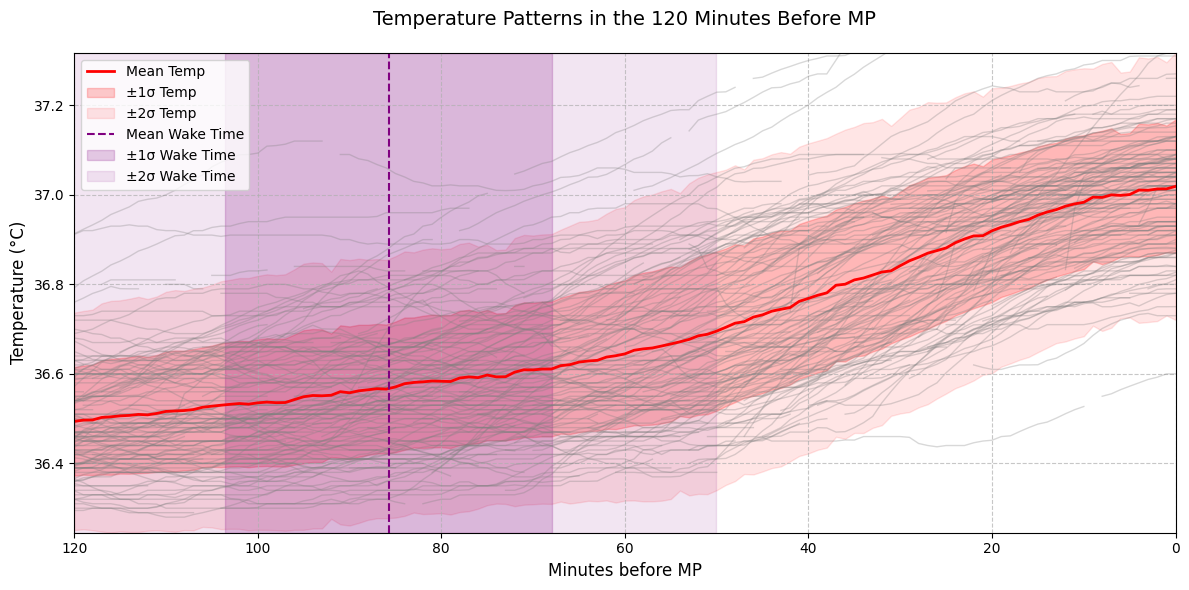

In [371]:

import matplotlib as plt
import circadian
reload(circadian)

fig = circadian.plot_pre_mp_periods_matplotlib(all_processed, merge_all_types(), 2 * 60)

# Looking at LEP through to MP and highlighting some days

In [372]:
import circadian
reload(circadian)

#test
#lep_to_mp_data = circadian.prepare_lep_to_mp_data(all_processed, merge_all_types(), highlight_days=['2025-03-20'])

<module 'circadian' from 'c:\\dev\\Brainwave-Processor\\notebooks\\CircadianDetection\\circadian.py'>

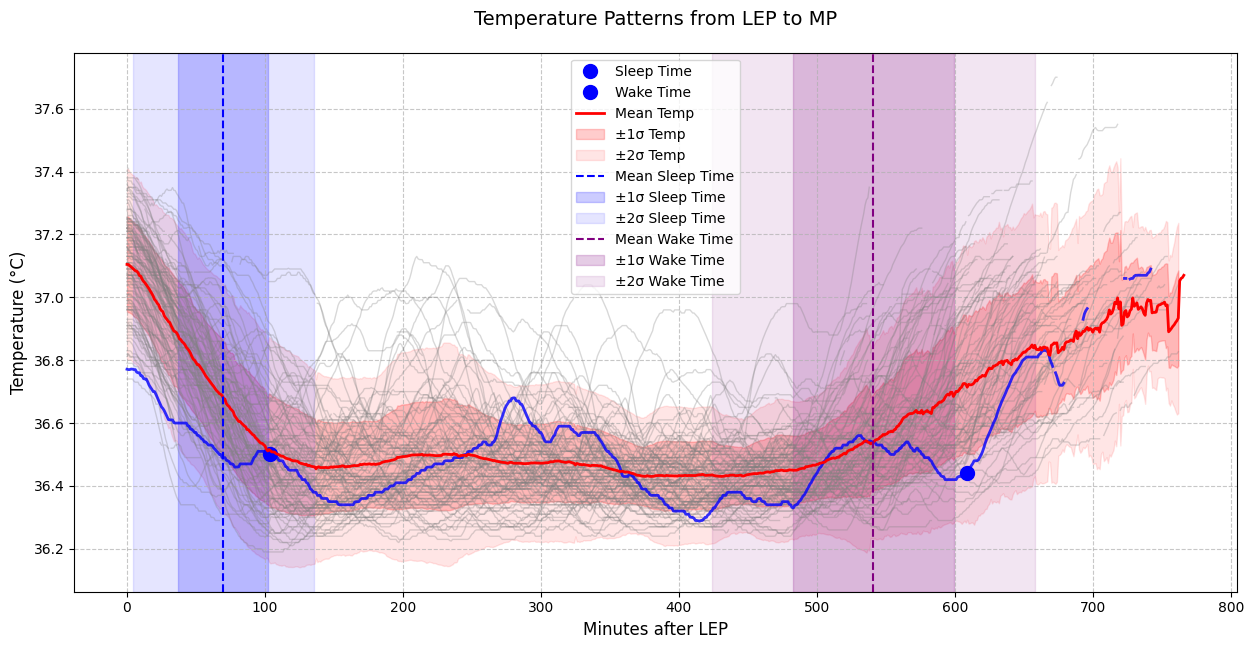

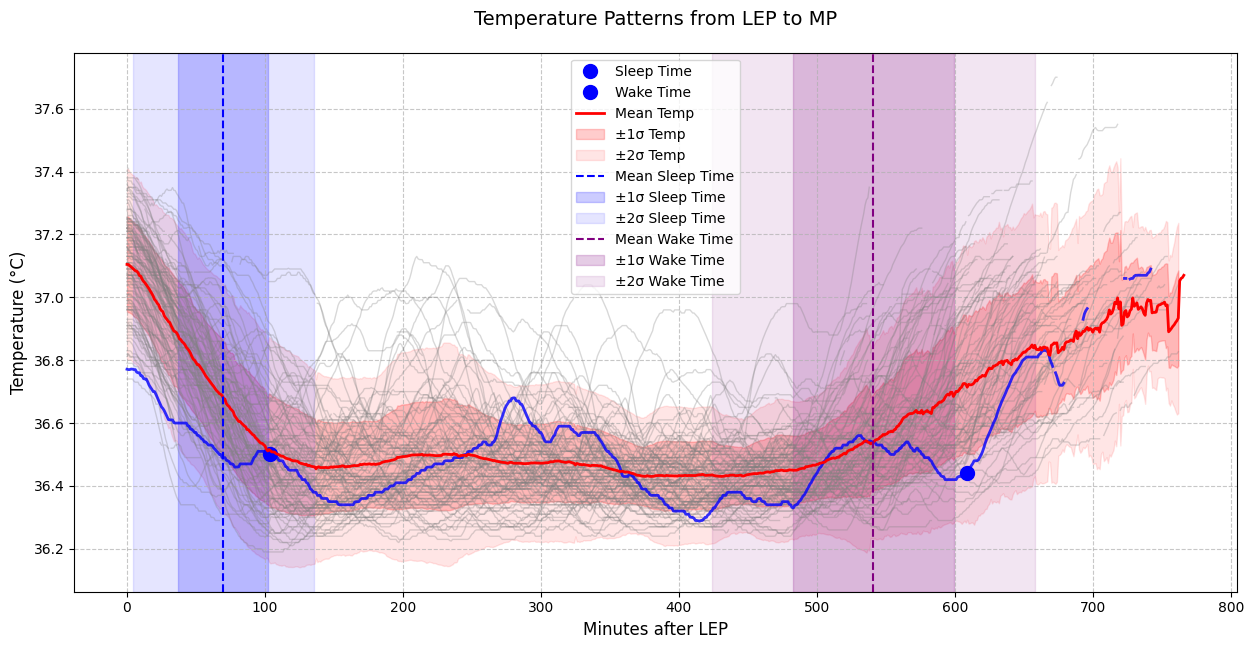

In [373]:
import circadian
reload(circadian)

circadian.plot_lep_to_mp_period(all_processed, merge_all_types(), highlight_days=['2025-03-16'])

# TODO: What is a desirable circadian rhythm?

What factors can I compare to:
* Length of sleep.

Is a long gap between MP and LEP good?  (Bearing in mind that means the overnight gap between LEP and the next day's MP will be reduced).  Or should it be a steady 12 hours?

Should the temp range be strong?

Should prominence of LEP and MP be high?


# TODO What controls CR?
Does morning light (intensity?), luminettes, adjust LEP (time, prominence, temp?)

# TODO: Look at peaks during night

# Styff


In [382]:
# Test
import circadian
reload(circadian)

day = '2025-03-26'
circadian.analyze_sleep_wake_timing_for_day(all_processed, merge_all_types(), all_processed[day], day, True)

KeyError: '2025-03-26'

In [380]:
m = merge_all_types()
m[m['dayAndNightOf'] == day]

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff,LT1_cr_datetime,...,MP_diff,LT1_merge_datetime,LT1_merge_temp,LT1_merge_prominence,MP_merge_datetime,MP_merge_temp,MP_merge_prominence,LEP_merge_datetime,LEP_merge_temp,LEP_merge_prominence
246,2025-03-17,NaT,NaN,NaN,Not found,No usable peaks found,NaT,NaN,NaT,NaT,...,0 days 00:55:00,2025-03-17 23:41:00+00:00,36.22,NaN,2025-03-17 08:54:00+00:00,37.09,0.15,NaT,NaN,NaN


In [374]:
import circadian
reload(circadian)

timing_df = circadian.analyze_sleep_wake_timing(all_processed, merge_all_types())
timing_df.head()

,date,sleep_mins_after_lep,wake_mins_after_lep,sleep_time,wake_time,lep_time,sleep_vs_mean,wake_vs_mean
0,2024-07-14,14.0,1872.0,23:02,06:00,22:48,-61.9,-109.7
1,2024-07-17,-2.0,1928.0,23:26,07:36,23:28,-77.9,-53.7
2,2024-07-21,64.0,1912.0,23:44,06:32,22:40,-11.9,-69.7
3,2024-07-28,73.5,2031.0,23:39,08:17,22:26,-2.4,49.3
4,2024-08-05,149.5,2044.0,23:49,07:24,21:20,73.6,62.3
